In [1080]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

scaler = MinMaxScaler()

Read the data

In [1081]:
DIR_MEAT = '../udataset/meat_production.csv'
DIR_POVERTY = '../udataset/national_wealth_data_interpolated.csv'
# DIR_POVERTY = '../udataset/poverty_rate_US.csv'
df_meat = pd.read_csv(DIR_MEAT)
df_poverty = pd.read_csv(DIR_POVERTY)
df_poverty = df_poverty.rename(columns={'date': 'datetime'})
df_poverty
# df_poverty = df_poverty.drop(columns=['state'])

,datetime,below_poverty_line_percent,state
0,2010-01-01,15.300000,US
1,2010-02-01,15.376255,US
2,2010-03-01,15.444212,US
3,2010-04-01,15.517420,US
4,2010-05-01,15.585230,US
...,...,...,...
140,2021-09-01,12.740984,US
141,2021-10-01,12.716317,US
142,2021-11-01,12.684449,US
143,2021-12-01,12.646753,US


Change label format to be lower + underscores instead of space

In [1082]:
df_meat.columns = df_meat.columns.str.lower().str.replace(' ', '_')
df_poverty.columns = df_poverty.columns.str.lower().str.replace(' ', '_')

Change date format to better use together

In [1083]:
df_meat['datetime'] = pd.to_datetime(df_meat['datetime'])
df_poverty['datetime'] = pd.to_datetime(df_poverty['datetime'])
# df_poverty['year'] = pd.to_datetime(df_poverty['year'].astype(str) + '-01-01')
# df_poverty = df_poverty.rename(columns={'year': 'datetime'})
df_poverty

,datetime,below_poverty_line_percent,state
0,2010-01-01,15.300000,US
1,2010-02-01,15.376255,US
2,2010-03-01,15.444212,US
3,2010-04-01,15.517420,US
4,2010-05-01,15.585230,US
...,...,...,...
140,2021-09-01,12.740984,US
141,2021-10-01,12.716317,US
142,2021-11-01,12.684449,US
143,2021-12-01,12.646753,US


In [1084]:
df_meat = df_meat.iloc[::-1]
df_meat.reset_index(drop=True, inplace=True)
df_meat

,datetime,beef,veal,pork,lamb_and_mutton,broilers,other_chicken,turkey
0,2001-01-01,2.172000e+09,17000000.0,1.672000e+09,18000000.0,2.622200e+09,42700000.0,403400000.0
1,2001-02-01,1.852000e+09,15000000.0,1.467000e+09,17000000.0,2.322200e+09,39700000.0,461200000.0
2,2001-03-01,2.065000e+09,16000000.0,1.606000e+09,23000000.0,2.588600e+09,44400000.0,409300000.0
3,2001-04-01,1.910000e+09,15000000.0,1.514000e+09,19000000.0,2.515700e+09,42200000.0,462000000.0
4,2001-05-01,2.265000e+09,15000000.0,1.535000e+09,16000000.0,2.835600e+09,45600000.0,428800000.0
...,...,...,...,...,...,...,...,...
271,2023-08-01,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,51100000.0,433500000.0
272,2023-09-01,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,48400000.0,489200000.0
273,2023-10-01,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,50600000.0,431200000.0
274,2023-11-01,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,44500000.0,500300000.0


In [1085]:
df_poverty = df_poverty.rename(columns={'below_poverty_line_percent': 'poverty_rate'})

Plot meat data

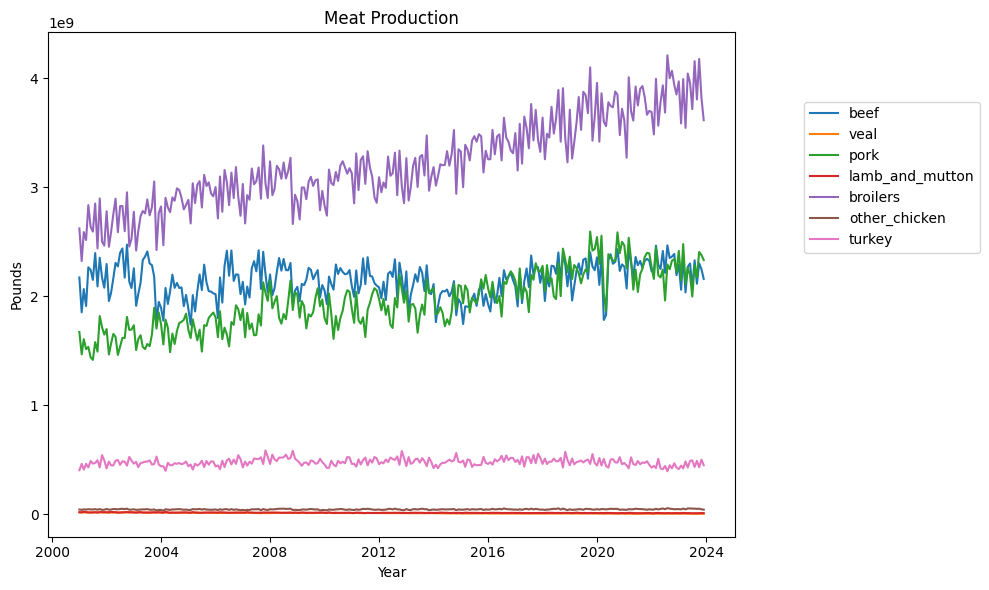

In [1086]:
df_temp = pd.melt(df_meat, id_vars='datetime', var_name='meat', value_name='amount')
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=df_temp, x='datetime', y='amount', hue='meat')
ax.set_title('Meat Production')
ax.set_xlabel('Year')
ax.set_ylabel('Pounds')
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=5)

plt.tight_layout()
plt.show()

Plot unemployment data

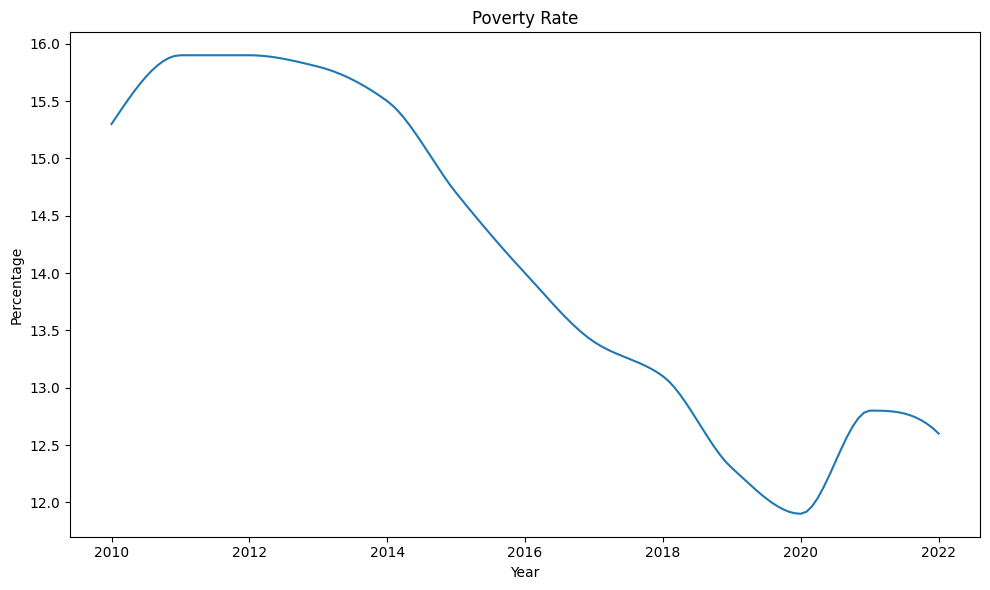

In [1087]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=df_poverty, x='datetime', y='poverty_rate')
ax.set_title('Poverty Rate')
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
plt.tight_layout()
plt.show()

Calculate and plot rolling mean and std for meat

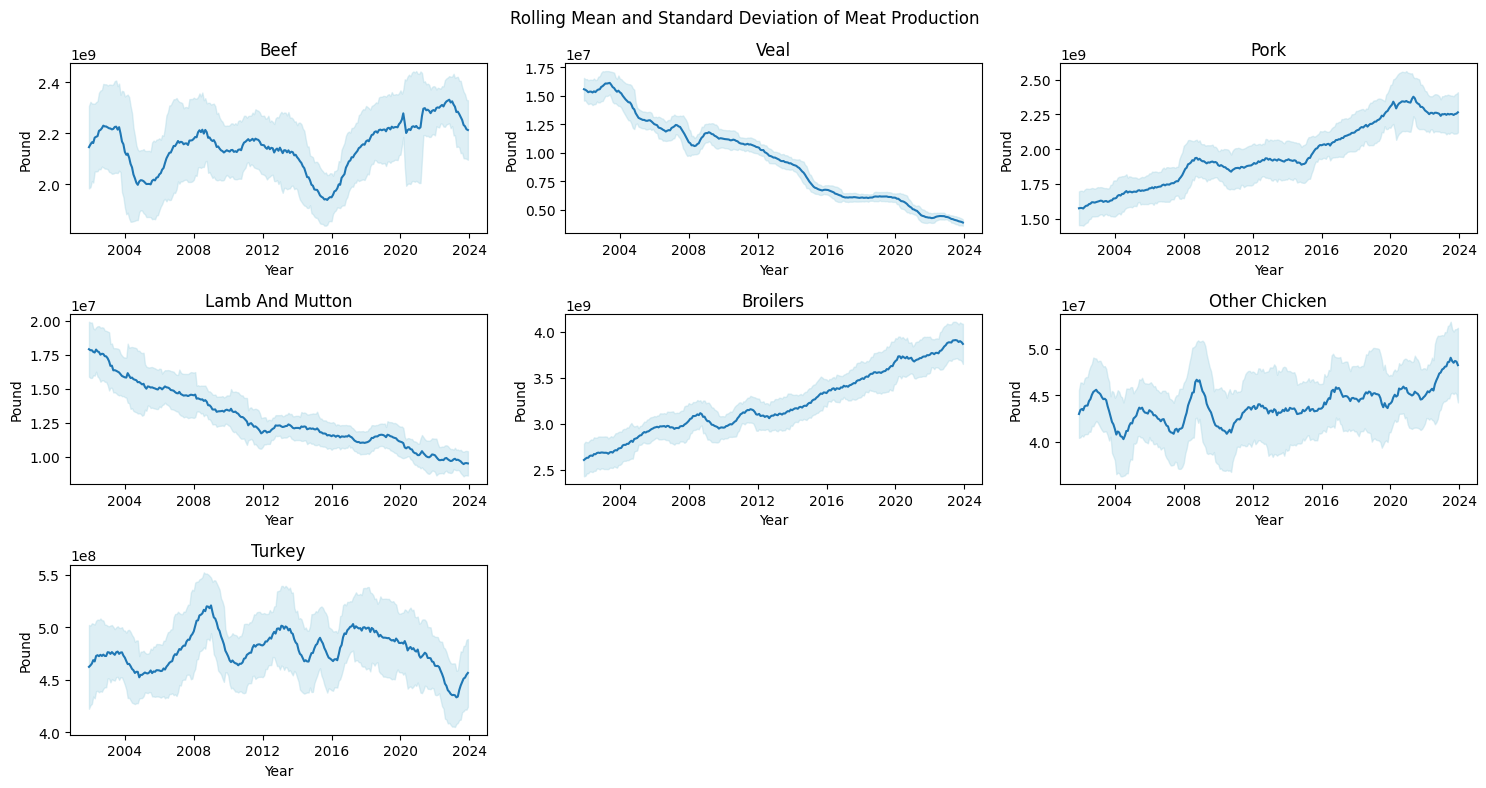

In [1088]:
meat_type = ['beef', 'veal', 'pork', 'lamb_and_mutton', 'broilers', 'other_chicken', 'turkey']
df_temp = df_meat.copy()
for meat in meat_type:
    df_temp[f'rolling_mean_{meat}'] = df_temp[meat].rolling(window=12).mean()
    df_temp[f'rolling_std_{meat}'] = df_temp[meat].rolling(window=12).std()
df_temp = df_temp.dropna()

plt.figure(figsize=(15, 8))
plt.suptitle('Rolling Mean and Standard Deviation of Meat Production')
for i, meat in enumerate(meat_type):
    mean = df_temp[f'rolling_mean_{meat}']
    std = df_temp[f'rolling_std_{meat}']
    ax = plt.subplot(3, 3, i+1)
    sns.lineplot(data=df_temp, x='datetime', y=f'rolling_mean_{meat}', ax=ax)
    ax.fill_between(df_temp['datetime'], mean-std, mean+std, color='lightblue', alpha=0.4)
    title = meat.replace('_', ' ').title()
    ax.set_title(title)
    ax.set_ylabel('Pound')
    ax.set_xlabel('Year')
    # ax2 = ax.twinx()
    # sns.lineplot(data=df_poverty, x='datetime', y='poverty_rate', color='black', label='Poverty (%)', ax=ax2)
    # ax2.set_ylabel('Poverty Rate (%)')

plt.tight_layout()
plt.show()

Check for stationarity

In [1089]:
def test_stationarity(timeseries, title):
    title = title.replace('_', ' ').title()

    result = adfuller(timeseries, autolag='AIC')
    adf_stat = result[0]
    p_val = result[1]
    used_lag = result[2]
    n_obs = result[3]
    critical_val = result[4]
    icbest = result[5]

    # Print the results in a more structured report format
    print(f"Augmented Dickey-Fuller Test Results for {title}:")
    print("-------------------------------------")
    print(f"Test Statistic: {adf_stat:.4f}")
    print(f"P-value: {p_val:.4f}")
    print(f"Number of Lags Used: {used_lag}")
    print(f"Number of Observations Used: {n_obs}")
    print("Critical Values:")
    for key, value in critical_val.items():
        print(f"    {key} ({value:.4f})")
    print(f"Information Criterion (best): {icbest:.4f}")

    # Provide a basic conclusion
    print("Conclusion:")
    if p_val < 0.05:
        print("The time series is stationary with 95% confidence.")
    else:
        print("The time series is not stationary. Consider differencing or detrending.")

for meat in meat_type:
    test_stationarity(df_meat[meat], meat)
    print('\n')

Augmented Dickey-Fuller Test Results for Beef:
-------------------------------------
Test Statistic: -2.3142
P-value: 0.1674
Number of Lags Used: 15
Number of Observations Used: 260
Critical Values:
    1% (-3.4558)
    5% (-2.8727)
    10% (-2.5727)
Information Criterion (best): 10241.1854
Conclusion:
The time series is not stationary. Consider differencing or detrending.


Augmented Dickey-Fuller Test Results for Veal:
-------------------------------------
Test Statistic: -0.9159
P-value: 0.7827
Number of Lags Used: 16
Number of Observations Used: 259
Critical Values:
    1% (-3.4559)
    5% (-2.8728)
    10% (-2.5728)
Information Criterion (best): 7625.8539
Conclusion:
The time series is not stationary. Consider differencing or detrending.


Augmented Dickey-Fuller Test Results for Pork:
-------------------------------------
Test Statistic: -0.9238
P-value: 0.7800
Number of Lags Used: 15
Number of Observations Used: 260
Critical Values:
    1% (-3.4558)
    5% (-2.8727)
    10% (-2.

Decompose data into trend and seasonal

Augmented Dickey-Fuller Test Results for Beef:
-------------------------------------
Test Statistic: -6.5883
P-value: 0.0000
Number of Lags Used: 14
Number of Observations Used: 249
Critical Values:
    1% (-3.4569)
    5% (-2.8732)
    10% (-2.5730)
Information Criterion (best): 9611.9662
Conclusion:
The time series is stationary with 95% confidence.


Augmented Dickey-Fuller Test Results for Veal:
-------------------------------------
Test Statistic: -7.9959
P-value: 0.0000
Number of Lags Used: 15
Number of Observations Used: 248
Critical Values:
    1% (-3.4570)
    5% (-2.8733)
    10% (-2.5730)
Information Criterion (best): 7106.2852
Conclusion:
The time series is stationary with 95% confidence.


Augmented Dickey-Fuller Test Results for Pork:
-------------------------------------
Test Statistic: -7.6245
P-value: 0.0000
Number of Lags Used: 15
Number of Observations Used: 248
Critical Values:
    1% (-3.4570)
    5% (-2.8733)
    10% (-2.5730)
Information Criterion (best): 9526.10

,datetime,residual_beef,residual_veal,residual_pork,residual_lamb_and_mutton,residual_broilers,residual_other_chicken,residual_turkey
6,2001-07-01,-5.473226e+07,-2.676294e+05,-5.032828e+05,-9.904830e+05,-4.566509e+07,-2.127794e+06,-1.038325e+07
7,2001-08-01,9.776092e+07,1.553204e+06,2.125884e+07,5.475852e+05,7.412336e+07,-1.270407e+06,6.768640e+06
8,2001-09-01,-8.235177e+07,-1.127478e+06,-6.268737e+07,-1.143703e+06,-2.112058e+08,-3.295786e+06,1.449951e+07
9,2001-10-01,6.505183e+07,1.143355e+06,6.307967e+07,1.077888e+06,6.751938e+07,1.116903e+06,-2.202625e+07
10,2001-11-01,1.892740e+07,5.304766e+05,3.590827e+07,1.219934e+06,-1.092929e+06,-6.207860e+05,1.917300e+07
...,...,...,...,...,...,...,...,...
265,2023-02-01,2.260997e+07,1.444918e+05,-7.859533e+06,5.941761e+05,-5.664520e+07,-4.427557e+05,8.470486e+05
266,2023-03-01,1.319435e+08,-6.762942e+04,1.366653e+08,3.835227e+03,5.500896e+07,3.091714e+06,8.095723e+06
267,2023-04-01,-9.290234e+07,-1.572128e+05,-9.373378e+07,-5.329072e+05,-2.811499e+08,-3.959612e+06,2.323057e+07
268,2023-05-01,3.805316e+07,3.884312e+05,1.197261e+08,3.634943e+05,8.350745e+07,3.026184e+06,-1.237795e+07


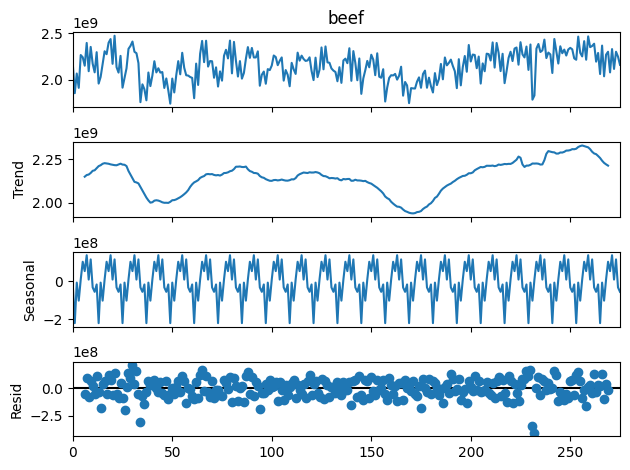

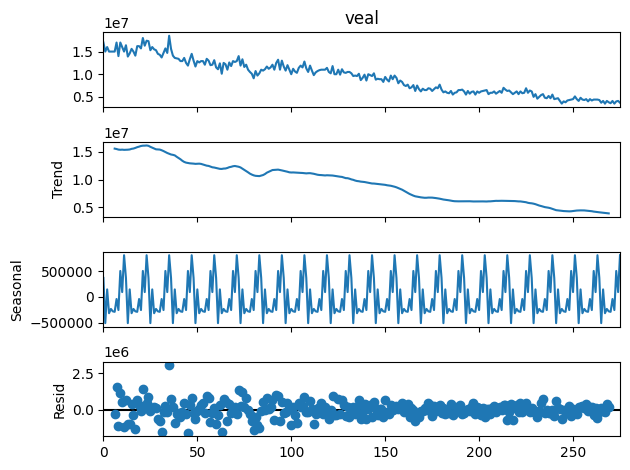

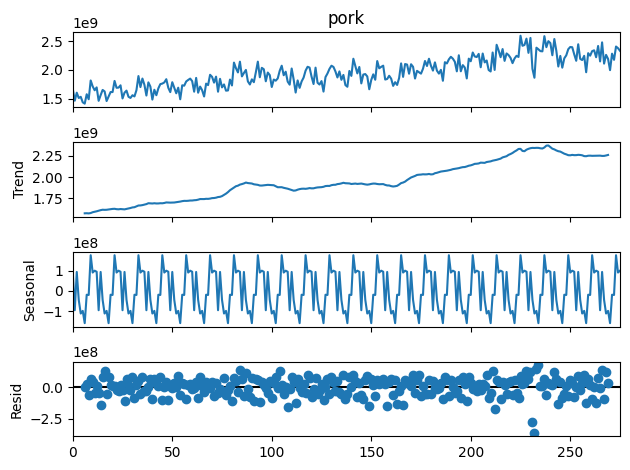

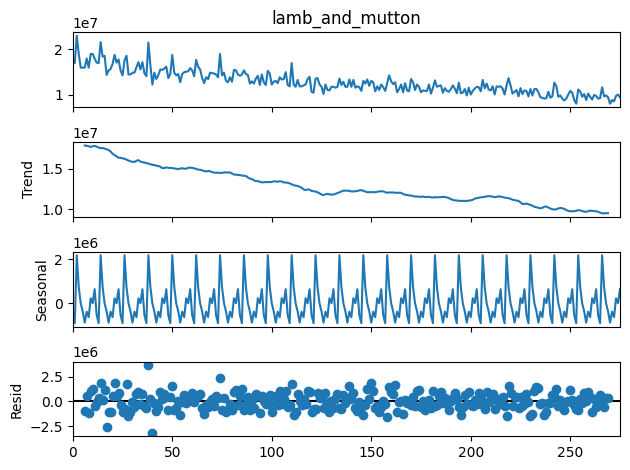

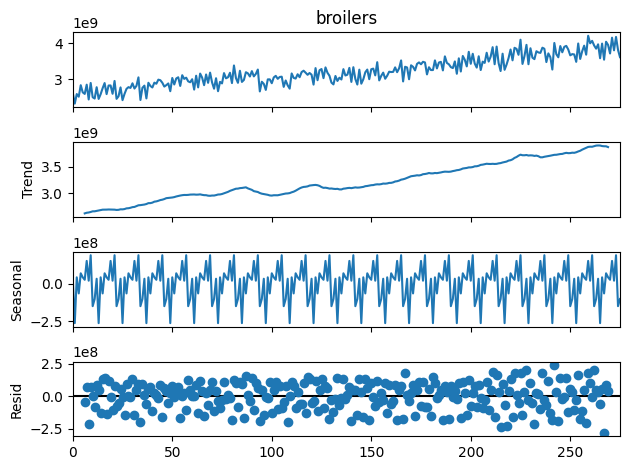

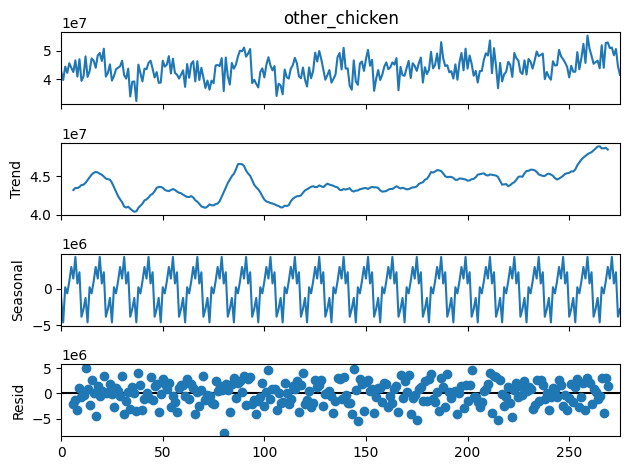

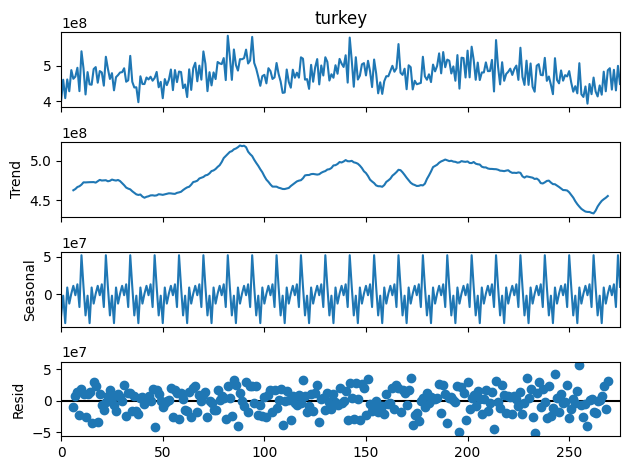

In [1090]:
df_meat_resid = df_meat.copy()
for meat in meat_type:
    decomposition = seasonal_decompose(df_meat[meat], model='additive', period=12)
    residual = decomposition.resid
    decomposition.plot()
    df_meat_resid[f'residual_{meat}'] = residual

df_meat_resid = df_meat_resid.dropna()
for meat in meat_type:
    test_stationarity(df_meat_resid[f'residual_{meat}'], meat)
    print('\n')

df_meat_resid = df_meat_resid.drop(columns=meat_type)
df_meat_resid

Check if poverty rates is stationary

In [1091]:
test_stationarity(df_poverty['poverty_rate'], 'poverty_rate')

Augmented Dickey-Fuller Test Results for Poverty Rate:
-------------------------------------
Test Statistic: -0.9472
P-value: 0.7720
Number of Lags Used: 14
Number of Observations Used: 130
Critical Values:
    1% (-3.4817)
    5% (-2.8840)
    10% (-2.5788)
Information Criterion (best): -1071.2821
Conclusion:
The time series is not stationary. Consider differencing or detrending.


Get residual from seasonal trend decomposition

Augmented Dickey-Fuller Test Results for Poverty Rate:
-------------------------------------
Test Statistic: -2.3564
P-value: 0.1544
Number of Lags Used: 13
Number of Observations Used: 119
Critical Values:
    1% (-3.4865)
    5% (-2.8862)
    10% (-2.5799)
Information Criterion (best): -1029.2385
Conclusion:
The time series is not stationary. Consider differencing or detrending.


,datetime,state,residual_poverty
6,2010-07-01,US,0.034355
7,2010-08-01,US,0.042436
8,2010-09-01,US,0.047472
9,2010-10-01,US,0.048563
10,2010-11-01,US,0.048629
...,...,...,...
134,2021-03-01,US,0.040503
135,2021-04-01,US,0.029309
136,2021-05-01,US,0.023948
137,2021-06-01,US,0.023973


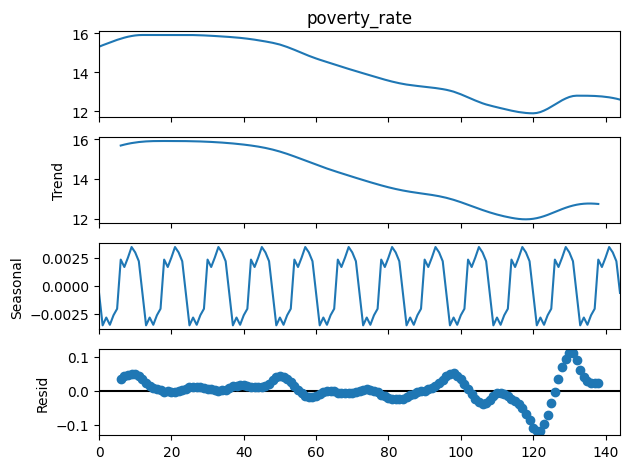

In [1092]:
df_poverty_resid = df_poverty.copy()
decomposition = seasonal_decompose(df_poverty['poverty_rate'], model='additive', period=12)
decomposition.plot()
residual = decomposition.resid
df_poverty_resid[f'residual_poverty'] = residual
df_poverty_resid = df_poverty_resid.dropna()
test_stationarity(df_poverty_resid['residual_poverty'], 'poverty_rate')

df_poverty_resid = df_poverty_resid.drop(columns=['poverty_rate'])
df_poverty_resid

Get correlation between the different meat types and poverty

In [1093]:
common_start = max(df_meat_resid['datetime'].min(), df_poverty_resid['datetime'].min())
common_end = min(df_meat_resid['datetime'].max(), df_poverty_resid['datetime'].max())

df_meat_resid = df_meat_resid[(df_meat_resid['datetime'] >= common_start) & (df_meat_resid['datetime'] <= common_end)]
df_poverty_resid = df_poverty_resid[(df_poverty_resid['datetime'] >= common_start) & (df_poverty_resid['datetime'] <= common_end)]

merged_df = pd.merge(df_meat_resid, df_poverty_resid, on='datetime')

# Get correlation between each meat type and poverty rate
correlation = {}
for meat in meat_type:
    correlation[meat] = merged_df[f'residual_{meat}'].corr(merged_df['residual_poverty'], method='kendall')

# Format the correlation values and print them
print("Correlation between Meat Production and Poverty Rate:")
print("-------------------------------------")
for cor in correlation:
    print(f"{cor.replace('_', ' ').title()}: {correlation[cor]:.4f}")


Correlation between Meat Production and Poverty Rate:
-------------------------------------
Beef: -0.0157
Veal: -0.0100
Pork: -0.0128
Lamb And Mutton: -0.0006
Broilers: -0.0021
Other Chicken: -0.0096
Turkey: -0.0210


Plotting residual data for each meat types


      datetime             meat        amount
0   2010-07-01    residual_beef -1.461559e+07
1   2010-08-01    residual_beef -4.895991e+07
2   2010-09-01    residual_beef  3.819823e+07
3   2010-10-01    residual_beef -8.796067e+07
4   2010-11-01    residual_beef  6.707323e+07
..         ...              ...           ...
926 2021-03-01  residual_turkey -1.177511e+07
927 2021-04-01  residual_turkey  4.223474e+07
928 2021-05-01  residual_turkey  4.034549e+06
929 2021-06-01  residual_turkey -1.703553e+07
930 2021-07-01  residual_turkey  1.102925e+07

[931 rows x 3 columns]


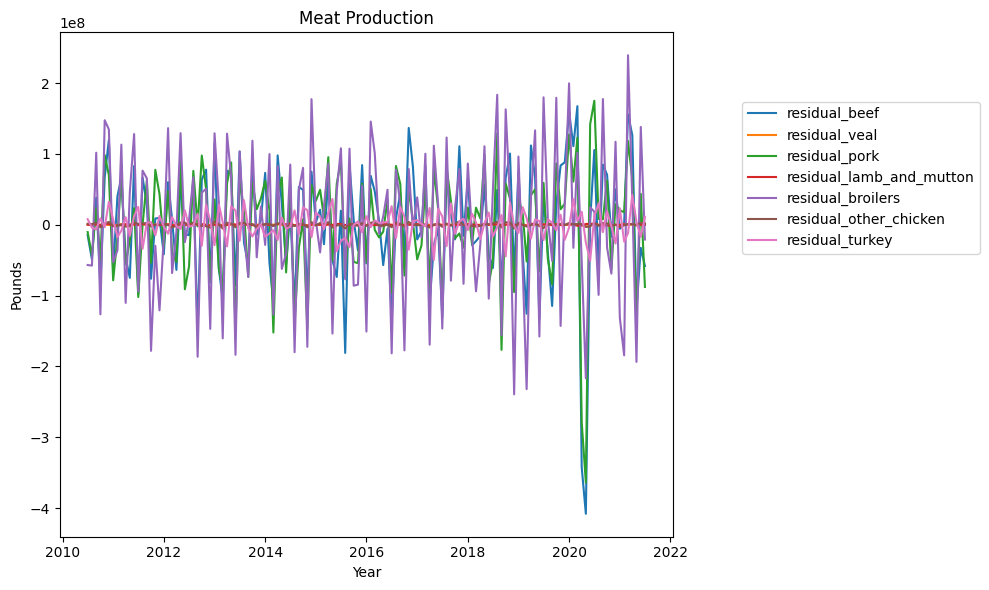

In [1094]:
df_temp = pd.melt(df_meat_resid, id_vars='datetime', var_name='meat', value_name='amount')
print(df_temp)
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=df_temp, x='datetime', y='amount', hue='meat')
ax.set_title('Meat Production')
ax.set_xlabel('Year')
ax.set_ylabel('Pounds')
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=5)

plt.tight_layout()
plt.show()